<a href="https://colab.research.google.com/github/kitigai/LearnDL/blob/master/anime_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
from google.colab import files

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kazumamorita","key":"bf28470b91244908fb4819bede7c7a4a"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  
vishnuvarthanrao/windows-store                              Windows Store                                     93KB  2020-07-07 12:29:07            934  
vzrenggamani/hanacaraka                                     Aksara Jawa / Hanacaraka                           9MB  2020-07-10 15:09:31             54  
rohanrao/chai-time-data-science                             Chai Time Data Science | CTDS.Show                 3MB  2020-07-23 17:23:46            676  
garystafford/environmental-sensor-data-132k                 Environmental Sensor Telemetry Data                7MB  2020-07-20 17:18:10            236  
moezabid/zillow-all-homes-data                              Zillow All Homes Data 

In [5]:
#kaggle competitions download -c 'name-of-competition'
! kaggle datasets download -d soumikrakshit/anime-faces

 99% 435M/441M [00:11<00:00, 50.6MB/s]
100% 441M/441M [00:11<00:00, 40.4MB/s]


In [ ]:
! unzip anime-faces.zip -d anime-faces

In [7]:
import imageio
import glob
import numpy as np
faces = []
for im_path in glob.glob("anime-faces/data/data/*.png"):
  im = imageio.imread(im_path)
  faces.append(im)
faces = np.array(faces)

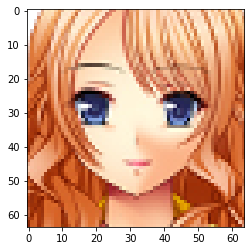

In [8]:
from matplotlib import pyplot as plt

plt.imshow(faces[1])

In [9]:

from keras.models import Sequential
from keras.layers import ZeroPadding2D, Activation, Input, LeakyReLU, Reshape, MaxPooling2D, Conv2D, Conv2DTranspose, ReLU, Dropout
from keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers.normalization import BatchNormalization
#from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
# import datasets
from keras.datasets import fashion_mnist
# for progress bar
from IPython.display import HTML, display
import time


Using TensorFlow backend.


In [10]:
class GAN():
  def __init__(self):
    self.img_rows = 64
    self.img_cols = 64
    self.channels = 3
    self.img_shape = (self.img_rows, self.img_cols, self.channels)

    optimizer = Adam(1e-4)

    self.discriminator = self.define_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    self.generator = self.define_generator()
    self.generator.compile(loss='binary_crossentropy', optimizer = optimizer)

    z = Input(shape=(100,))
    img = self.generator(z)

    self.discriminator.trainable = False

    valid = self.discriminator(img)

    self.combined = Model(z, valid)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  def define_generator(self):
    noise_shape = (100, )
    model = Sequential()

    model.add(Dense(4*4*512, input_shape=noise_shape, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((4,4,512)))
    assert model.output_shape == (None, 4, 4, 512) # Note: None is the batch size
    model.add(Conv2DTranspose(512, kernel_size=(4,4), strides=(2,2), padding="same", use_bias=False, kernel_initializer= TruncatedNormal(stddev=0.02)))
    assert model.output_shape == (None, 8, 8, 512) # Note: None is the batch size
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding="same", use_bias=False, kernel_initializer= TruncatedNormal(stddev=0.02)))
    assert model.output_shape == (None, 16, 16, 256) # Note: None is the batch size
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding="same", use_bias=False, kernel_initializer= TruncatedNormal(stddev=0.02)))
    assert model.output_shape == (None, 32, 32, 128) # Note: None is the batch size
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), padding="same", use_bias=False, kernel_initializer= TruncatedNormal(stddev=0.02)))
    assert model.output_shape == (None, 64, 64, 64) # Note: None is the batch size
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, kernel_size=(4,4), strides=(1,1), padding="same", use_bias=False, activation='tanh', kernel_initializer= TruncatedNormal(stddev=0.02)))
    assert model.output_shape == (None, 64, 64, 3) # Note: None is the batch size

    noise =  Input(shape=noise_shape)
    img = model(noise)
    
    return(Model(noise, img))

  def define_discriminator(self):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=self.img_shape)
    validity = model(img)

    return(Model(img, validity))

  def train(self, epochs, batch_size=128, save_interval=50):

    # reshape into 0 - 1
    X_train = (faces - 127.5) / 127.5
    # add channel dim
    #X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)
    # prepareing progress bar
    out = display(self.progress(0, 100), display_id=True)
    for epoch in range(epochs):

      #train discriminator
      #self.generator.trainable = False
      #self.discriminator.trainable = True
      idx = np.random.randint(0, X_train.shape[0], half_batch)
      imgs = X_train[idx]

      noise = np.random.normal(0, 1, (half_batch, 100))
      gen_imgs = self.generator.predict(noise)
      d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      #train generator
      #self.generator.trainable = True
      #self.discriminator.trainable = False
      noise = np.random.normal(0, 1, (batch_size, 100))
      valid_y = np.array([1] * batch_size)
      g_loss = self.combined.train_on_batch(noise, valid_y)
      #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
      out.update(self.progress(epoch % save_interval, save_interval))
      # If at save interval => save generated image samples
      if epoch % save_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        self.save_imgs(epoch)
  
  def save_imgs(self, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = self.generator.predict(noise)
    print(gen_imgs.shape)
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    #plt.imshow(gen_imgs[0,:,:,0])
    plt.imshow(gen_imgs[0])
    plt.show()
        
    fig, axs = plt.subplots(r, c)
    cnt = 0

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            #axs[i,j].imshow(gen_imgs[cnt], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    #fig.savefig("gan/images/mnist_%d.png" % epoch)
    plt.show()
    plt.close()

  def progress(self, value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


In [11]:
gan = GAN()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 3.055456, acc.: 15.62%] [G loss: 0.097587]
(25, 64, 64, 3)


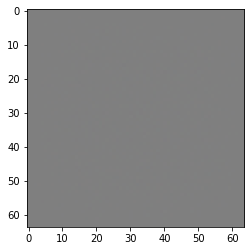

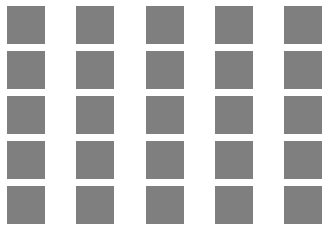

1000 [D loss: 0.018735, acc.: 100.00%] [G loss: 2.012964]
(25, 64, 64, 3)


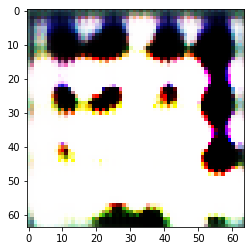

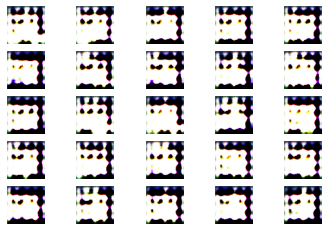

2000 [D loss: 0.000100, acc.: 100.00%] [G loss: 17.344421]
(25, 64, 64, 3)


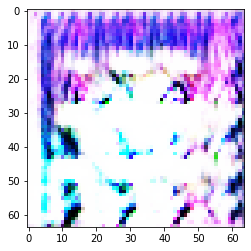

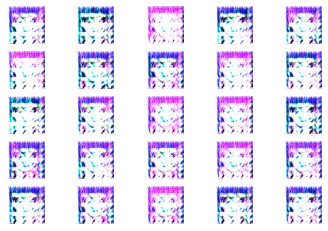

3000 [D loss: 0.000356, acc.: 100.00%] [G loss: 0.010389]
(25, 64, 64, 3)


4000 [D loss: 0.004286, acc.: 100.00%] [G loss: 2.393403]
(25, 64, 64, 3)


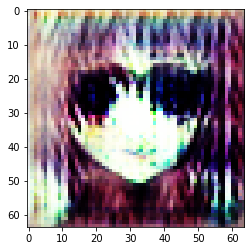

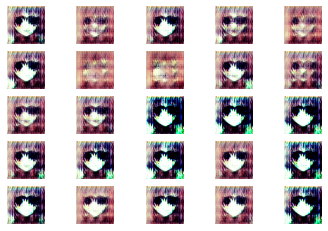

5000 [D loss: 0.011913, acc.: 100.00%] [G loss: 4.696315]
(25, 64, 64, 3)


6000 [D loss: 0.022876, acc.: 100.00%] [G loss: 5.593419]
(25, 64, 64, 3)


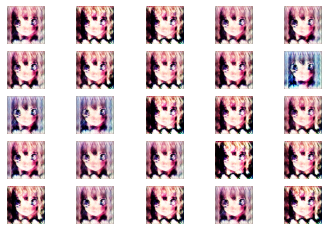

7000 [D loss: 0.000530, acc.: 100.00%] [G loss: 0.244452]
(25, 64, 64, 3)


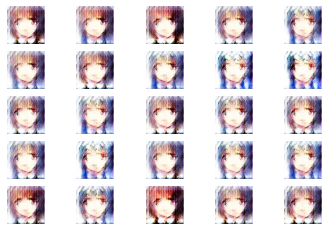

8000 [D loss: 0.003814, acc.: 100.00%] [G loss: 6.150760]
(25, 64, 64, 3)


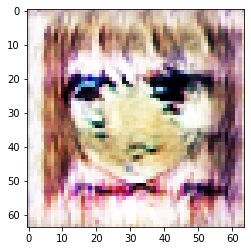

9000 [D loss: 0.019589, acc.: 100.00%] [G loss: 6.109525]
(25, 64, 64, 3)


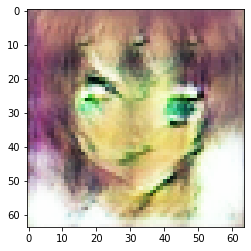

10000 [D loss: 0.002412, acc.: 100.00%] [G loss: 0.057816]
(25, 64, 64, 3)


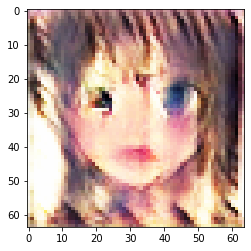

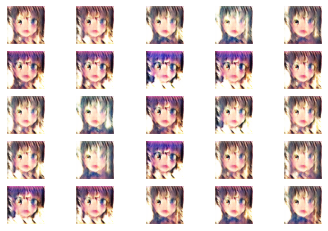

11000 [D loss: 0.000017, acc.: 100.00%] [G loss: 11.627610]
(25, 64, 64, 3)


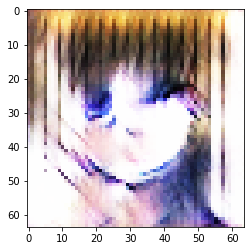

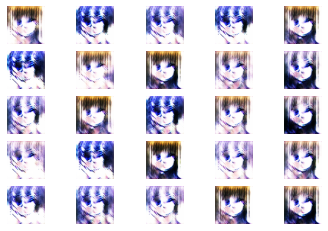

12000 [D loss: 0.019266, acc.: 100.00%] [G loss: 3.105251]
(25, 64, 64, 3)


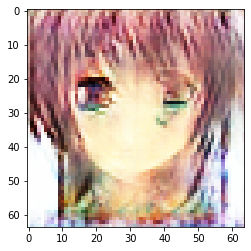

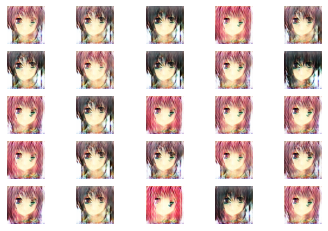

13000 [D loss: 0.014054, acc.: 100.00%] [G loss: 7.347179]
(25, 64, 64, 3)


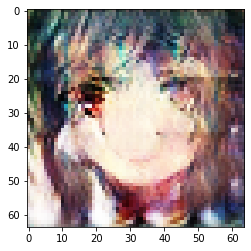

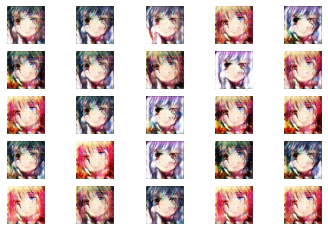

14000 [D loss: 0.021752, acc.: 100.00%] [G loss: 1.661768]
(25, 64, 64, 3)


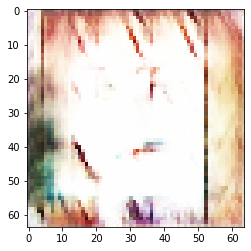

15000 [D loss: 0.065285, acc.: 100.00%] [G loss: 4.326142]
(25, 64, 64, 3)


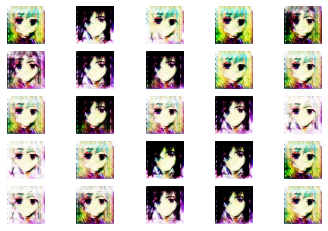

16000 [D loss: 0.001557, acc.: 100.00%] [G loss: 6.129319]
(25, 64, 64, 3)


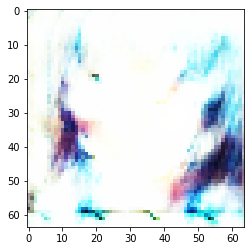

17000 [D loss: 0.047385, acc.: 96.88%] [G loss: 3.257792]
(25, 64, 64, 3)


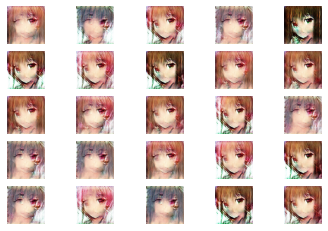

18000 [D loss: 0.073110, acc.: 96.88%] [G loss: 5.674340]
(25, 64, 64, 3)


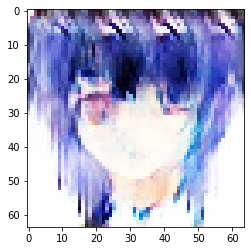

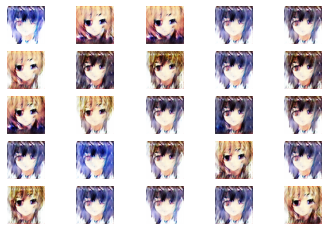

19000 [D loss: 0.000584, acc.: 100.00%] [G loss: 9.975763]
(25, 64, 64, 3)


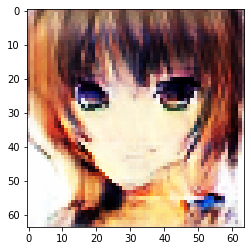

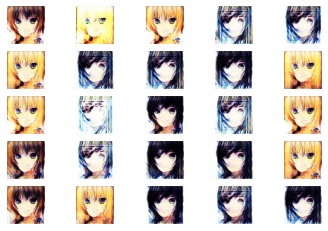

20000 [D loss: 0.008480, acc.: 100.00%] [G loss: 4.515531]
(25, 64, 64, 3)


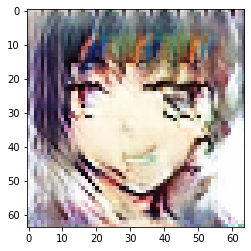

21000 [D loss: 0.013932, acc.: 100.00%] [G loss: 6.341763]
(25, 64, 64, 3)


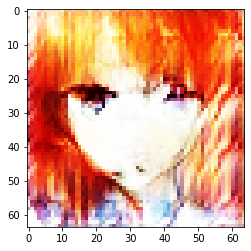

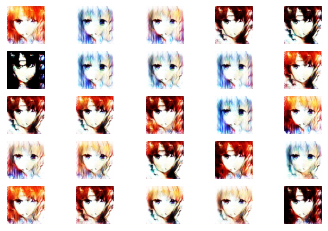

22000 [D loss: 0.002233, acc.: 100.00%] [G loss: 6.912100]
(25, 64, 64, 3)


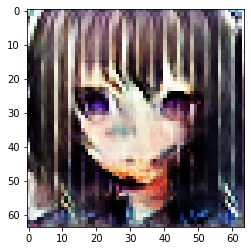

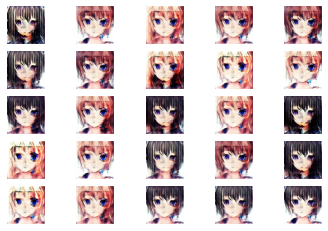

23000 [D loss: 0.059901, acc.: 96.88%] [G loss: 7.547835]
(25, 64, 64, 3)


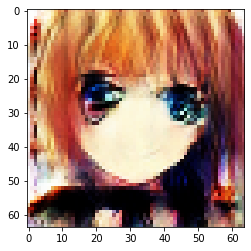

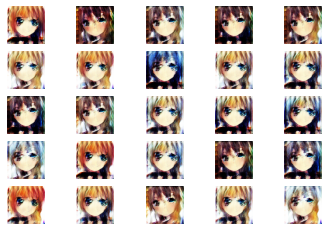

24000 [D loss: 0.074062, acc.: 96.88%] [G loss: 4.533637]
(25, 64, 64, 3)


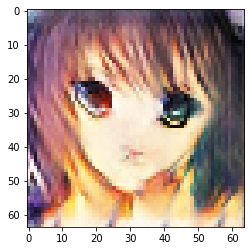

25000 [D loss: 0.000845, acc.: 100.00%] [G loss: 7.025376]
(25, 64, 64, 3)


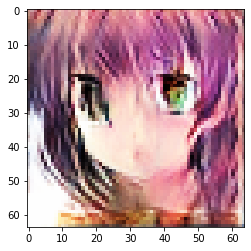

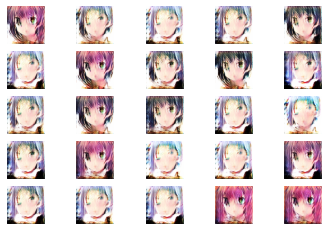

26000 [D loss: 0.000713, acc.: 100.00%] [G loss: 8.305943]
(25, 64, 64, 3)


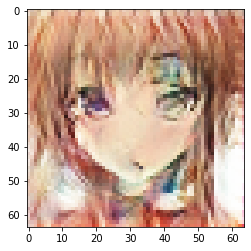

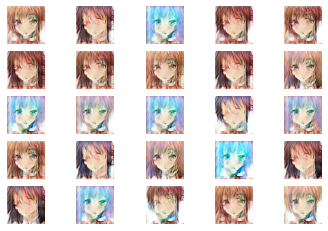

27000 [D loss: 0.001139, acc.: 100.00%] [G loss: 9.429480]
(25, 64, 64, 3)


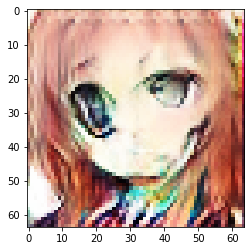

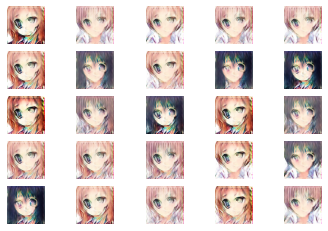

28000 [D loss: 0.053360, acc.: 96.88%] [G loss: 9.599679]
(25, 64, 64, 3)


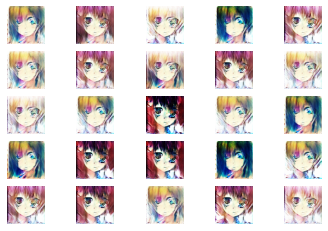

29000 [D loss: 0.007182, acc.: 100.00%] [G loss: 5.711076]
(25, 64, 64, 3)


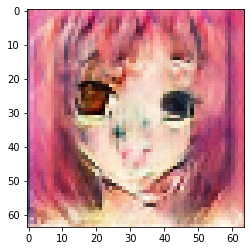

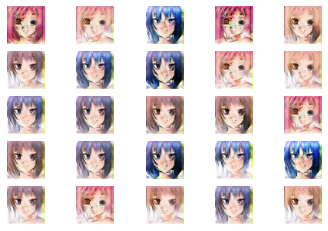

In [ ]:
gan.train(epochs=30000, batch_size=32, save_interval=1000)

In [1]:
noise = np.random.normal(0, 1, (4, 100))
imgs = gan.generator.predict(noise)
plt.imshow(imgs[0])

NameError: ignored